In [150]:

message('loading libraries...')
library(ape)
library(phangorn)
library(Matrix)
library(tidyverse)

message('loading user parameters')

seq_len <- 1000
tree_file <- '~/hbv_covar3/analysis/sim_seq/simseq_N800_90.tree'
coev_factor <- 4
run_ind <- 1
u <- 1.25
covar_desc_size <- 100

message('loading tree files...')
# get the population size from the tree file
tree <- read.tree(tree_file)
pop_size <- length(tree$tip.label)
# set the run id
param_set <- paste0("l", seq_len, "n", pop_size, "f", coev_factor, "u", u)
run_id <- paste0(param_set, "_", run_ind)

message("seq_len: ", seq_len, "\n",
        "tree_file: ", tree_file, "\n",
        "pop_size: ", pop_size, "\n",
        "coev_factor: ", coev_factor, "\n",
        "run_ind: ", run_ind, "\n",
        "u: ", u, "\n")


# set the output file
outfile <- paste0("~/hbv_covar3/analysis/sim_seq/", param_set, "/simseq_", run_id, "rescaled.fasta")



loading libraries...

loading user parameters

loading tree files...

seq_len: 1000
tree_file: ~/hbv_covar3/analysis/sim_seq/simseq_N800_90.tree
pop_size: 800
coev_factor: 4
run_ind: 1
u: 1.25




In [151]:
# set bases of the sequences, assuming biallelic for all sites
bases <- c("x", "y")
coev_pair <- c("yy", "xx")

message("setting Q matrices...")
# set Q of independant sites
Q <- matrix(c(-1*u, u, u, -1*u), nrow = 2, ncol = 2)
colnames(Q) <- bases
rownames(Q) <- bases

# set Q of coevolving site pairs
base_pairs <- expand.grid(bases, bases)
base_pairs <- paste0(base_pairs[, 1], base_pairs[, 2])
Qco <- matrix(nrow = 4, ncol = 4)
colnames(Qco) <- base_pairs
rownames(Qco) <- base_pairs

# siteA is independantly evolving, siteB is following siteA
for (i in 1:nrow(Qco)) {
    for (j in 1:ncol(Qco)) {
        # skip if there is no change on either sites
        if (i == j) {
            next
        }
        siteA_change <- c(strsplit(base_pairs[i], "")[[1]][1], strsplit(base_pairs[j], "")[[1]][1])
        siteB_change <- c(strsplit(base_pairs[i], "")[[1]][2], strsplit(base_pairs[j], "")[[1]][2])

        # treat changes in both sites simultaneously as impossible to happen
        if (siteA_change[1] != siteA_change[2] && siteB_change[1] != siteB_change[2]) {
            Qco[i, j] <- 0
            next
        }

        # treat one site changes as the changes in the independant model
        # first, get the changing base
        base_change <- NA
        if (siteA_change[1] != siteA_change[2]) {
            base_change <- siteA_change
            # if the change is at siteA, and not at siteB, then this element is not influence by coev pair because siteA evolve idependantly
            Qco[i, j] <- Q[base_change[1], base_change[2]]
            next
        } else {
            base_change <- siteB_change
        }
        # get the rate of this chanage
        Qco[i, j] <- Q[base_change[1], base_change[2]]

        # now, consider if coevolution should be consider
        if (base_pairs[i] %in% coev_pair) {
            Qco[i, j] <- Qco[i, j] / coev_factor
        } else if (base_pairs[j] %in% coev_pair) {
            Qco[i, j] <- Qco[i, j] * coev_factor
        }
    }
}

for (i in 1:nrow(Qco)) {
    Qco[i, i] <- -1 * sum(Qco[i, ], na.rm = T)
}

# three site coevolution model
Qco3 <- matrix(nrow = 8, ncol = 8)
base_tri <- expand.grid(bases, bases, bases)
base_tri <- paste0(base_tri[, 1], base_tri[, 2], base_tri[, 3])
colnames(Qco3) <- base_tri
rownames(Qco3) <- base_tri
siteAB_coev_pair <- c("yy", "xx")
siteBC_coev_pair <- c("yy", "xx")
for (i in 1:nrow(Qco3)) {
    for (j in 1:ncol(Qco3)) {
        # skip if there is no change
        if (i == j) {
            next
        }
        siteA_change <- c(strsplit(base_tri[i], "")[[1]][1], strsplit(base_tri[j], "")[[1]][1])
        siteB_change <- c(strsplit(base_tri[i], "")[[1]][2], strsplit(base_tri[j], "")[[1]][2])
        siteC_change <- c(strsplit(base_tri[i], "")[[1]][3], strsplit(base_tri[j], "")[[1]][3])

        siteA_is_change <- as.numeric(siteA_change[1] != siteA_change[2])
        siteB_is_change <- as.numeric(siteB_change[1] != siteB_change[2])
        siteC_is_change <- as.numeric(siteC_change[1] != siteC_change[2])
        # treat changes in >2 sites simultaneously as impossible to happen
        if (siteA_is_change + siteB_is_change + siteC_is_change >= 2) {
            Qco3[i, j] <- 0
            next
        }
        # consider siteA change, this site is changing in independantly from other sites
        if (siteA_is_change == 1) {
            Qco3[i, j] <- Q[siteA_change[1], siteA_change[2]]
            next
        }
        # consider siteB change, this site is dependant on the second site
        if (siteB_is_change == 1) {
            # first set the change as if siteB is changing independantly
            Qco3[i, j] <- Q[siteB_change[1], siteB_change[2]]
            # get the bases that siteA and B are changing from
            baseAB <- paste0(siteA_change[1], siteB_change[1])
            if (baseAB %in% siteAB_coev_pair) {
                Qco3[i, j] <- Qco3[i, j] / coev_factor
            }
            # get the bases that siteA and B are changing into
            baseAB <- paste0(siteA_change[2], siteB_change[2])
            if (baseAB %in% siteAB_coev_pair) {
                Qco3[i, j] <- Qco3[i, j] * coev_factor
            }
            next
        }
        # consider siteC change, this site is dependant on the second site
        if (siteC_is_change == 1) {
            # first set the change as if siteC is changing independantly
            Qco3[i, j] <- Q[siteC_change[1], siteC_change[2]]
            # get the bases that siteB and C are changing from
            baseBC <- paste0(siteB_change[1], siteC_change[1])
            if (baseBC %in% siteBC_coev_pair) {
                Qco3[i, j] <- Qco3[i, j] / coev_factor
            }
            # get the bases that siteB and C are changing into
            baseBC <- paste0(siteB_change[2], siteC_change[2])
            if (baseBC %in% siteBC_coev_pair) {
                Qco3[i, j] <- Qco3[i, j] * coev_factor
            }
            next
        }
    }
}

message("Q matrix:")
print(Qco3)


for (i in 1:nrow(Qco3)) {
    Qco3[i, i] <- -1 * sum(Qco3[i, ], na.rm = T)
}




# function for sequence simulation
simseq <- function(tree, start_seq, levs, Q, cur_node = length(tree$tip.label) + 1, result = list(), head_run = T) {
    # get the starting state for each base in the sequence
    seq_states <- map(start_seq, function(cur_base) {
        as.numeric(cur_base == levs)
    })
    seq_states <- do.call(cbind, seq_states) # each column is the state of a base
    children <- Children(tree, cur_node)
    node_name <- paste0('iid', cur_node)
    result[[node_name]]  <- start_seq
    for (child in children) {
        # get branch length
        branch_len <- tree$edge.length[which(tree$edge[, 2] == child)]
        child_seq <- map_chr(1:ncol(seq_states), function(i) {
            # get the probability of the state after time t (the parent branch length)
            cur_state <- seq_states[, i]
            state_dist <- cur_state %*% expm(branch_len * Q)
            # get the base of the child based on the distribution
            cur_base <- sample(levs, 1, prob = as.vector(state_dist))
            return(cur_base)
        })
        if (child > length(tree$tip.label)) {
            # has not reached tip yet, go down another level
            child_result <- simseq(tree, child_seq, levs, Q, child)
            # concat child result to the current result
            result <- c(result, child_result)
        } else {
            node_name <- tree$tip.label[child]
            result[[node_name]] <- child_seq
        }
    }
    return(result)
}

sim_seq_ind <- function(tree, rate) {
    # function implementation

    # Create a comprehensive state array for all nodes
    all_node_states <- rep(0, Nnode(tree) + length(tree$tip.label))

    # Calculate total branch length
    total_branch_length <- sum(tree$edge.length)

    # Step 1: Determine number of substitution events
    num_events <- rpois(1, lambda = rate * total_branch_length)

    # Step 2: Determine the location of substitution events
    event_locations <- runif(num_events, min = 0, max = total_branch_length)

    # Initialize the alleles at all nodes (0 = ancestral allele, 1 = derived allele)
    tree$node.label <- rep(0, Nnode(tree))

    # Function to propagate change to descendant nodes
    propagateChange <- function(tree, node, newState, all_node_states) {
        all_node_states[node] <- newState
        descendants <- Descendants(tree, node, type = "all")
        all_node_states[descendants] <- newState
        return(all_node_states)
    }

    # Simulate allele changes at each event
    current_length <- 0
    node_ind <- 0
    for (event in sort(event_locations)) {
        while (current_length < event) {
            node_ind <- node_ind + 1
            current_length <- current_length + tree$edge.length[node_ind]
            
        }
        node <- tree$edge[node_ind, 2]
        newState <- 1 - all_node_states[node]
        all_node_states <- propagateChange(tree, node, newState, all_node_states)
    }

    # Step 4: Retrieve the allele each node
    alleles <- all_node_states
    names(alleles) <- c(tree$tip.label, paste0("iid", length(tree$tip.label)+(1:Nnode(tree))))
    return(alleles)
}


# simulate the coevolving sites
message("simulating coevolving sites...")
start_time <- Sys.time()
sim_result_coev <- simseq(tree, c("xxx"), base_tri, Qco3)
end_time <- Sys.time()
message("time used: " , end_time - start_time)


# put the simulation result into a matrix
sim_msa <- do.call(rbind, strsplit(unlist(sim_result_coev), ""))


# simulate the independant sites
message("simulating independant independant sites...")
start_time <- Sys.time()
sim_ind_result <- list()
for (site in 1:seq_len) {
    sim_ind_result[[site]] <- ifelse(sim_seq_ind(tree, u) == 1, "x", "y")
}
sim_ind_result <- do.call(cbind, sim_ind_result)
end_time <- Sys.time()
message("time used: " , end_time - start_time)



setting Q matrices...

Q matrix:



     xxx    yxx    xyx    yyx    xxy    yxy    xyy  yyy
xxx   NA 1.2500 0.3125 0.0000 0.3125 0.0000 0.0000 0.00
yxx 1.25     NA 0.0000 5.0000 0.0000 0.3125 0.0000 0.00
xyx 5.00 0.0000     NA 1.2500 0.0000 0.0000 5.0000 0.00
yyx 0.00 0.3125 1.2500     NA 0.0000 0.0000 0.0000 5.00
xxy 5.00 0.0000 0.0000 0.0000     NA 1.2500 0.3125 0.00
yxy 0.00 5.0000 0.0000 0.0000 1.2500     NA 0.0000 5.00
xyy 0.00 0.0000 0.3125 0.0000 5.0000 0.0000     NA 1.25
yyy 0.00 0.0000 0.0000 0.3125 0.0000 0.3125 1.2500   NA


simulating coevolving sites...

time used: 0.575128078460693

simulating independant independant sites...

time used: 9.51501655578613



In [152]:
sim_msa <- cbind(sim_msa, sim_ind_result[rownames(sim_msa), ])


In [194]:
# select a site where a co-mutation happens
desc_n <- map_dbl(1:(length(tree$tip.label) + Ntip(tree)), function(x) {
  length(unlist(Descendants(tree, x, type="tips")))
})

loop_cnt <- 0
covar_nodes <- NULL

while (length(covar_nodes) == 0) {
    covar_nodes <- which(desc_n == covar_desc_size-loop_cnt)
    loop_cnt <- loop_cnt + 1
}
if (length(covar_nodes) > 1) {
    covar_node <- sample(covar_nodes, 1)
} else {
    covar_node <- covar_nodes
}

# site4 and site5 have the co-mutation event on the node
print(covar_node)

[1] 1168


In [195]:
descendants <- Descendants(tree, covar_node, type = "all")


descendants_labels <- map_chr(descendants, function(x) {
    if (x <= length(tree$tip.label)){
        return(tree$tip.label[x])
    } else {
        return(paste0('iid', x))
    }
})

descendants_labels

[1] "iid1169" "iid1407" "iid1170" "iid1379" "iid1408" "iid1440" "iid1171"
  [8] "iid1291" "iid1380" "iid1390" "iid1409" "iid1414" "t360"    "t458"   
 [15] "iid1172" "iid1248" "iid1292" "iid1345" "iid1381" "iid1384" "iid1391"
 [22] "iid1392" "iid1410" "iid1412" "iid1415" "iid1436" "iid1173" "iid1192"
 [29] "iid1249" "iid1267" "iid1293" "iid1304" "iid1346" "iid1373" "t320"   
 [36] "iid1382" "iid1385" "t439"    "t531"    "t110"    "iid1393" "iid1397"
 [43] "t423"    "iid1411" "t449"    "iid1413" "iid1416" "iid1426" "iid1437"
 [50] "iid1438" "iid1174" "iid1180" "iid1193" "iid1194" "iid1250" "t501"   
 [57] "iid1268" "iid1290" "iid1294" "iid1303" "iid1305" "iid1341" "iid1347"
 [64] "iid1352" "iid1374" "iid1378" "iid1383" "t395"    "iid1386" "iid1389"
 [71] "iid1394" "t167"    "iid1398" "t216"    "t602"    "t181"    "t488"   
 [78] "t461"    "iid1417" "iid1420" "iid1427" "iid1428" "t361"    "t638"   
 [85] "iid1439" "t249"    "iid1175" "iid1179" "iid1181" "iid1187" "t499"   
 [92] "t676"    "iid1195" "iid1234" "t252"    "iid1251" "iid1269" "iid1281"
 [99] "t322"    "t420"    "iid1295" "iid1302" "t251"    "t606"    "iid1306"
[106] "iid1316" "iid1342" "t535"    "iid1348" "t741"    "iid1353" "iid1359"
[113] "iid1375" "t62"     "t709"    "t678"    "t59"     "t150"    "iid1387"
[120] "t542"    "t226"    "t767"    "iid1395" "iid1396" "iid1399" "iid1403"
[127] "t81"     "iid1418" "iid1421" "iid1424" "t89"     "t123"    "iid1429"
[134] "iid1432" "t698"    "t145"    "iid1176" "t114"    "t212"    "t172"   
[141] "t163"    "iid1182" "iid1188" "iid1189" "iid1196" "iid1218" "iid1235"
[148] "iid1246" "iid1252" "iid1257" "iid1270" "iid1273" "iid1282" "iid1287"
[155] "iid1296" "iid1300" "t403"    "t573"    "iid1307" "iid1313" "iid1317"
[162] "iid1339" "t198"    "iid1343" "iid1349" "iid1350" "t427"    "iid1354"
[169] "iid1360" "iid1368" "iid1376" "t559"    "iid1388" "t177"    "t470"   
[176] "t491"    "t86"     "t3"      "iid1400" "iid1402" "t270"    "iid1404"
[183] "t157"    "iid1419" "iid1422" "t23"     "t752"    "iid1425" "iid1430"
[190] "iid1431" "iid1433" "iid1434" "iid1177" "iid1178" "iid1183" "t785"   
[197] "t462"    "t656"    "iid1190" "iid1191" "iid1197" "iid1206" "iid1219"
[204] "iid1224" "iid1236" "iid1238" "iid1247" "t555"    "iid1253" "iid1254"
[211] "iid1258" "iid1260" "iid1271" "iid1272" "iid1274" "iid1279" "iid1283"
[218] "iid1285" "iid1288" "t311"    "iid1297" "iid1299" "iid1301" "t364"   
[225] "iid1308" "iid1310" "t136"    "iid1314" "iid1318" "iid1336" "t434"   
[232] "iid1340" "iid1344" "t687"    "t700"    "t657"    "iid1351" "t723"   
[239] "iid1355" "iid1358" "iid1361" "t597"    "iid1369" "iid1372" "iid1377"
[246] "t587"    "t690"    "t221"    "t20"     "iid1401" "t650"    "t384"   
[253] "t21"     "iid1405" "t515"    "t240"    "iid1423" "t605"    "t498"   
[260] "t379"    "t540"    "t400"    "t80"     "t753"    "t117"    "t509"   
[267] "t352"    "iid1435" "t282"    "t297"    "t302"    "t604"    "iid1184"
[274] "iid1185" "t305"    "t308"    "t118"    "t196"    "iid1198" "iid1200"
[281] "iid1207" "iid1216" "iid1220" "t432"    "iid1225" "iid1231" "t639"   
[288] "iid1237" "iid1239" "iid1244" "t633"    "t564"    "t129"    "t632"   
[295] "iid1255" "iid1256" "iid1259" "t745"    "iid1261" "iid1262" "t707"   
[302] "t617"    "t41"     "t405"    "iid1275" "iid1278" "iid1280" "t791"   
[309] "t91"     "iid1284" "t643"    "iid1286" "t155"    "iid1289" "t387"   
[316] "iid1298" "t25"     "t35"     "t543"    "t217"    "iid1309" "t290"   
[323] "iid1311" "t510"    "t579"    "iid1315" "iid1319" "iid1321" "t304"   
[330] "iid1337" "t273"    "t239"    "t393"    "t156"    "t623"    "t679"   
[337] "iid1356" "t259"    "t647"    "t520"    "iid1362" "iid1366" "t659"   
[344] "iid1370" "t135"    "t142"    "t399"    "t295"    "t195"    "t669"   
[351] "iid1406" "t229"    "t572"    "t468"    "t45"     "t27"     "t57"    
[358] "t763"    "t566"    "iid1186" "iid1199" "t550"    "iid1201" "iid1205"
[365] "iid1208" "iid1210" "iid1217" "t727"    "iid

In [196]:
mutate_xy <- function(nucleotide) {
    if (nucleotide == 'x') {
        return('y')
    } else if (nucleotide == 'y') {
        return('x')
    } else {
        stop(paste('unexpected nucleotide:', nucleotide))
    }
}

sim_msa_comut <- sim_msa
comut_sites <- c(4, 5)
for (site in comut_sites) {
    for (descendant in descendants_labels){
        sim_msa_comut[descendant, site] <- mutate_xy(sim_msa[descendant, site])
    }
}

node_labels <- c(paste0('t', 1:Ntip(tree)), paste0('iid', (Ntip(tree)+1):(Ntip(tree)+tree$Nnode)))


In [193]:
covar_desc_size <- 300


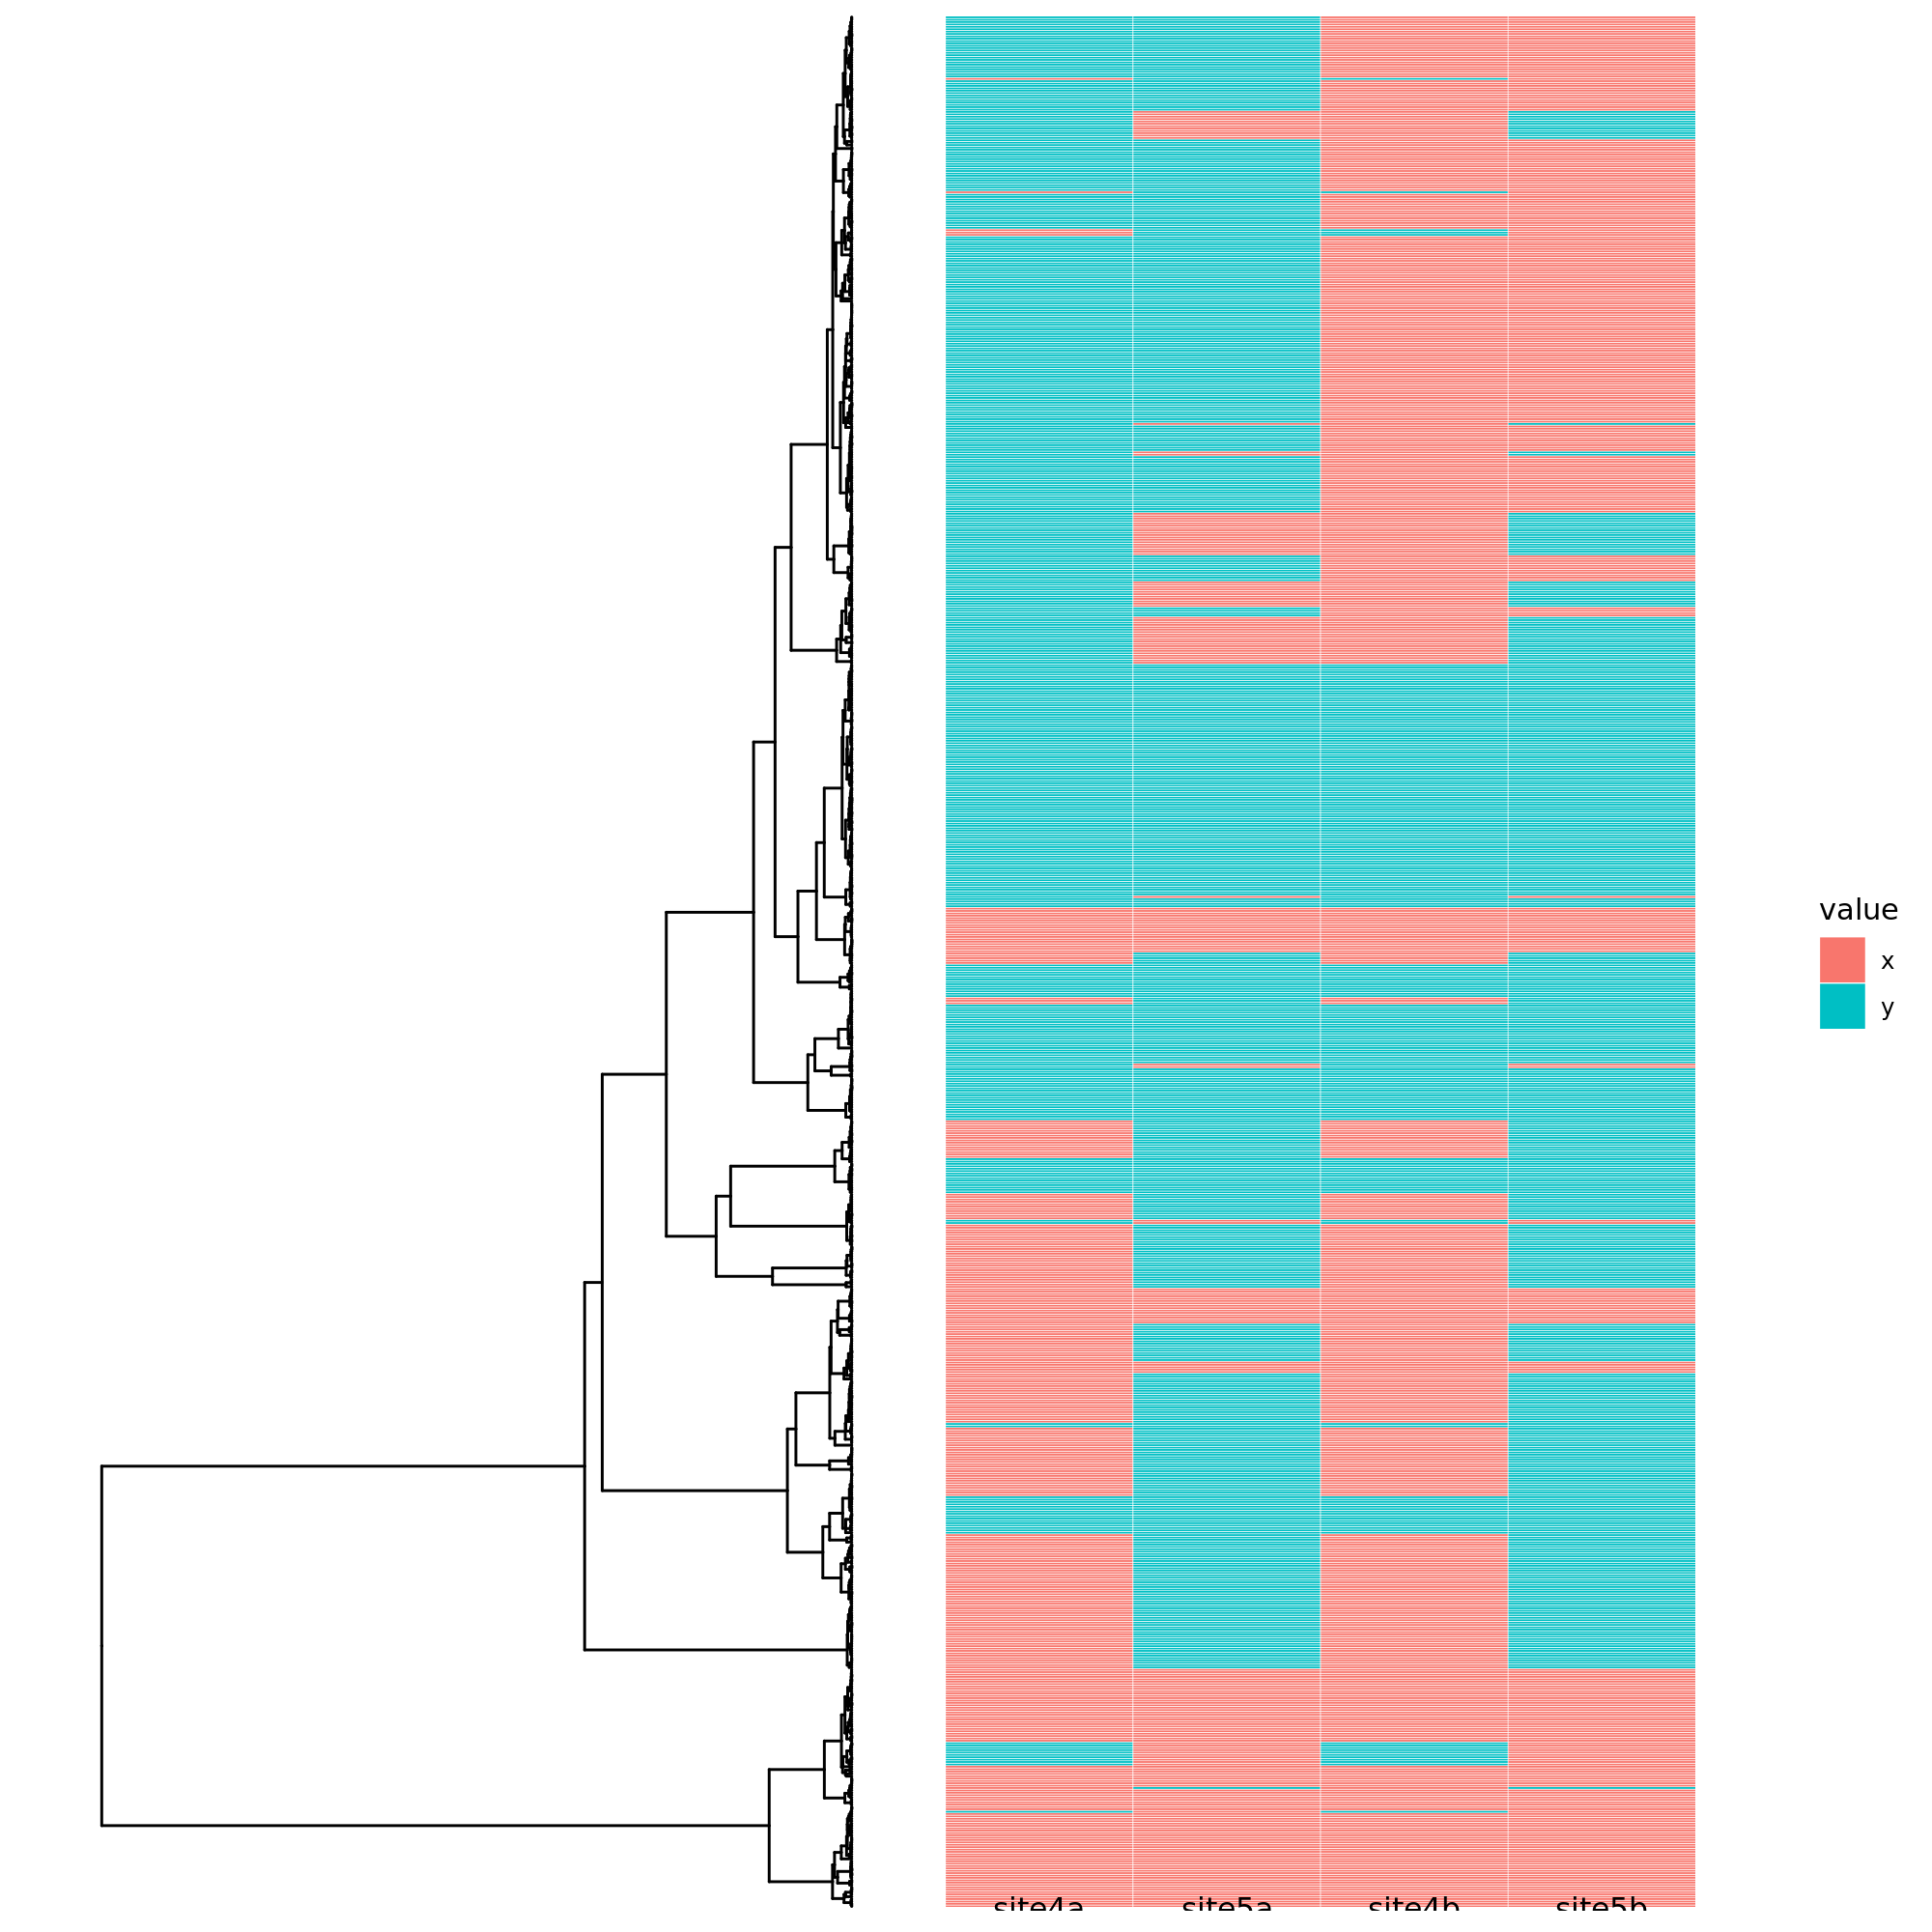

In [197]:
# visualise to check if the result actually occurred

options(repr.plot.width = 10, repr.plot.height = 10, repr.plot.res = 200)

library(ggtree)
library(patchwork)


node_data1 <- data.frame(node = 1:(tree$Nnode + Ntip(tree)),
                         site4 = sim_msa[node_labels, 4],
                         site5 = sim_msa[node_labels, 5])
node_data1_tip <- node_data1[which(node_data1$node <= Ntip(tree)), ]
rownames(node_data1_tip) <- node_labels[1:Ntip(tree)]
colnames(node_data1_tip) <- c('node', 'site4a', 'site5a')

node_data2 <- data.frame(node = 1:(tree$Nnode + Ntip(tree)),
                         site4 = sim_msa_comut[node_labels, 4],
                         site5 = sim_msa_comut[node_labels, 5])
node_data2_tip <- node_data2[which(node_data2$node <= Ntip(tree)), ]
rownames(node_data2_tip) <- node_labels[1:Ntip(tree)]
colnames(node_data2_tip) <- c('node', 'site4b', 'site5b')

node_data12_tip <- cbind(node_data1_tip, node_data2_tip)

p <- ggtree(tree)
gheatmap(p, node_data12_tip[, c('site4a', 'site5a', 'site4b', 'site5b')])


In [198]:
node_data1_tip$is_desc <- map_chr(rownames(node_data1_tip), function(x) {
    ifelse(x %in% descendants_labels, 'y', 'n')
})
table(node_data1_tip$is_desc)


  n   y 
526 274 

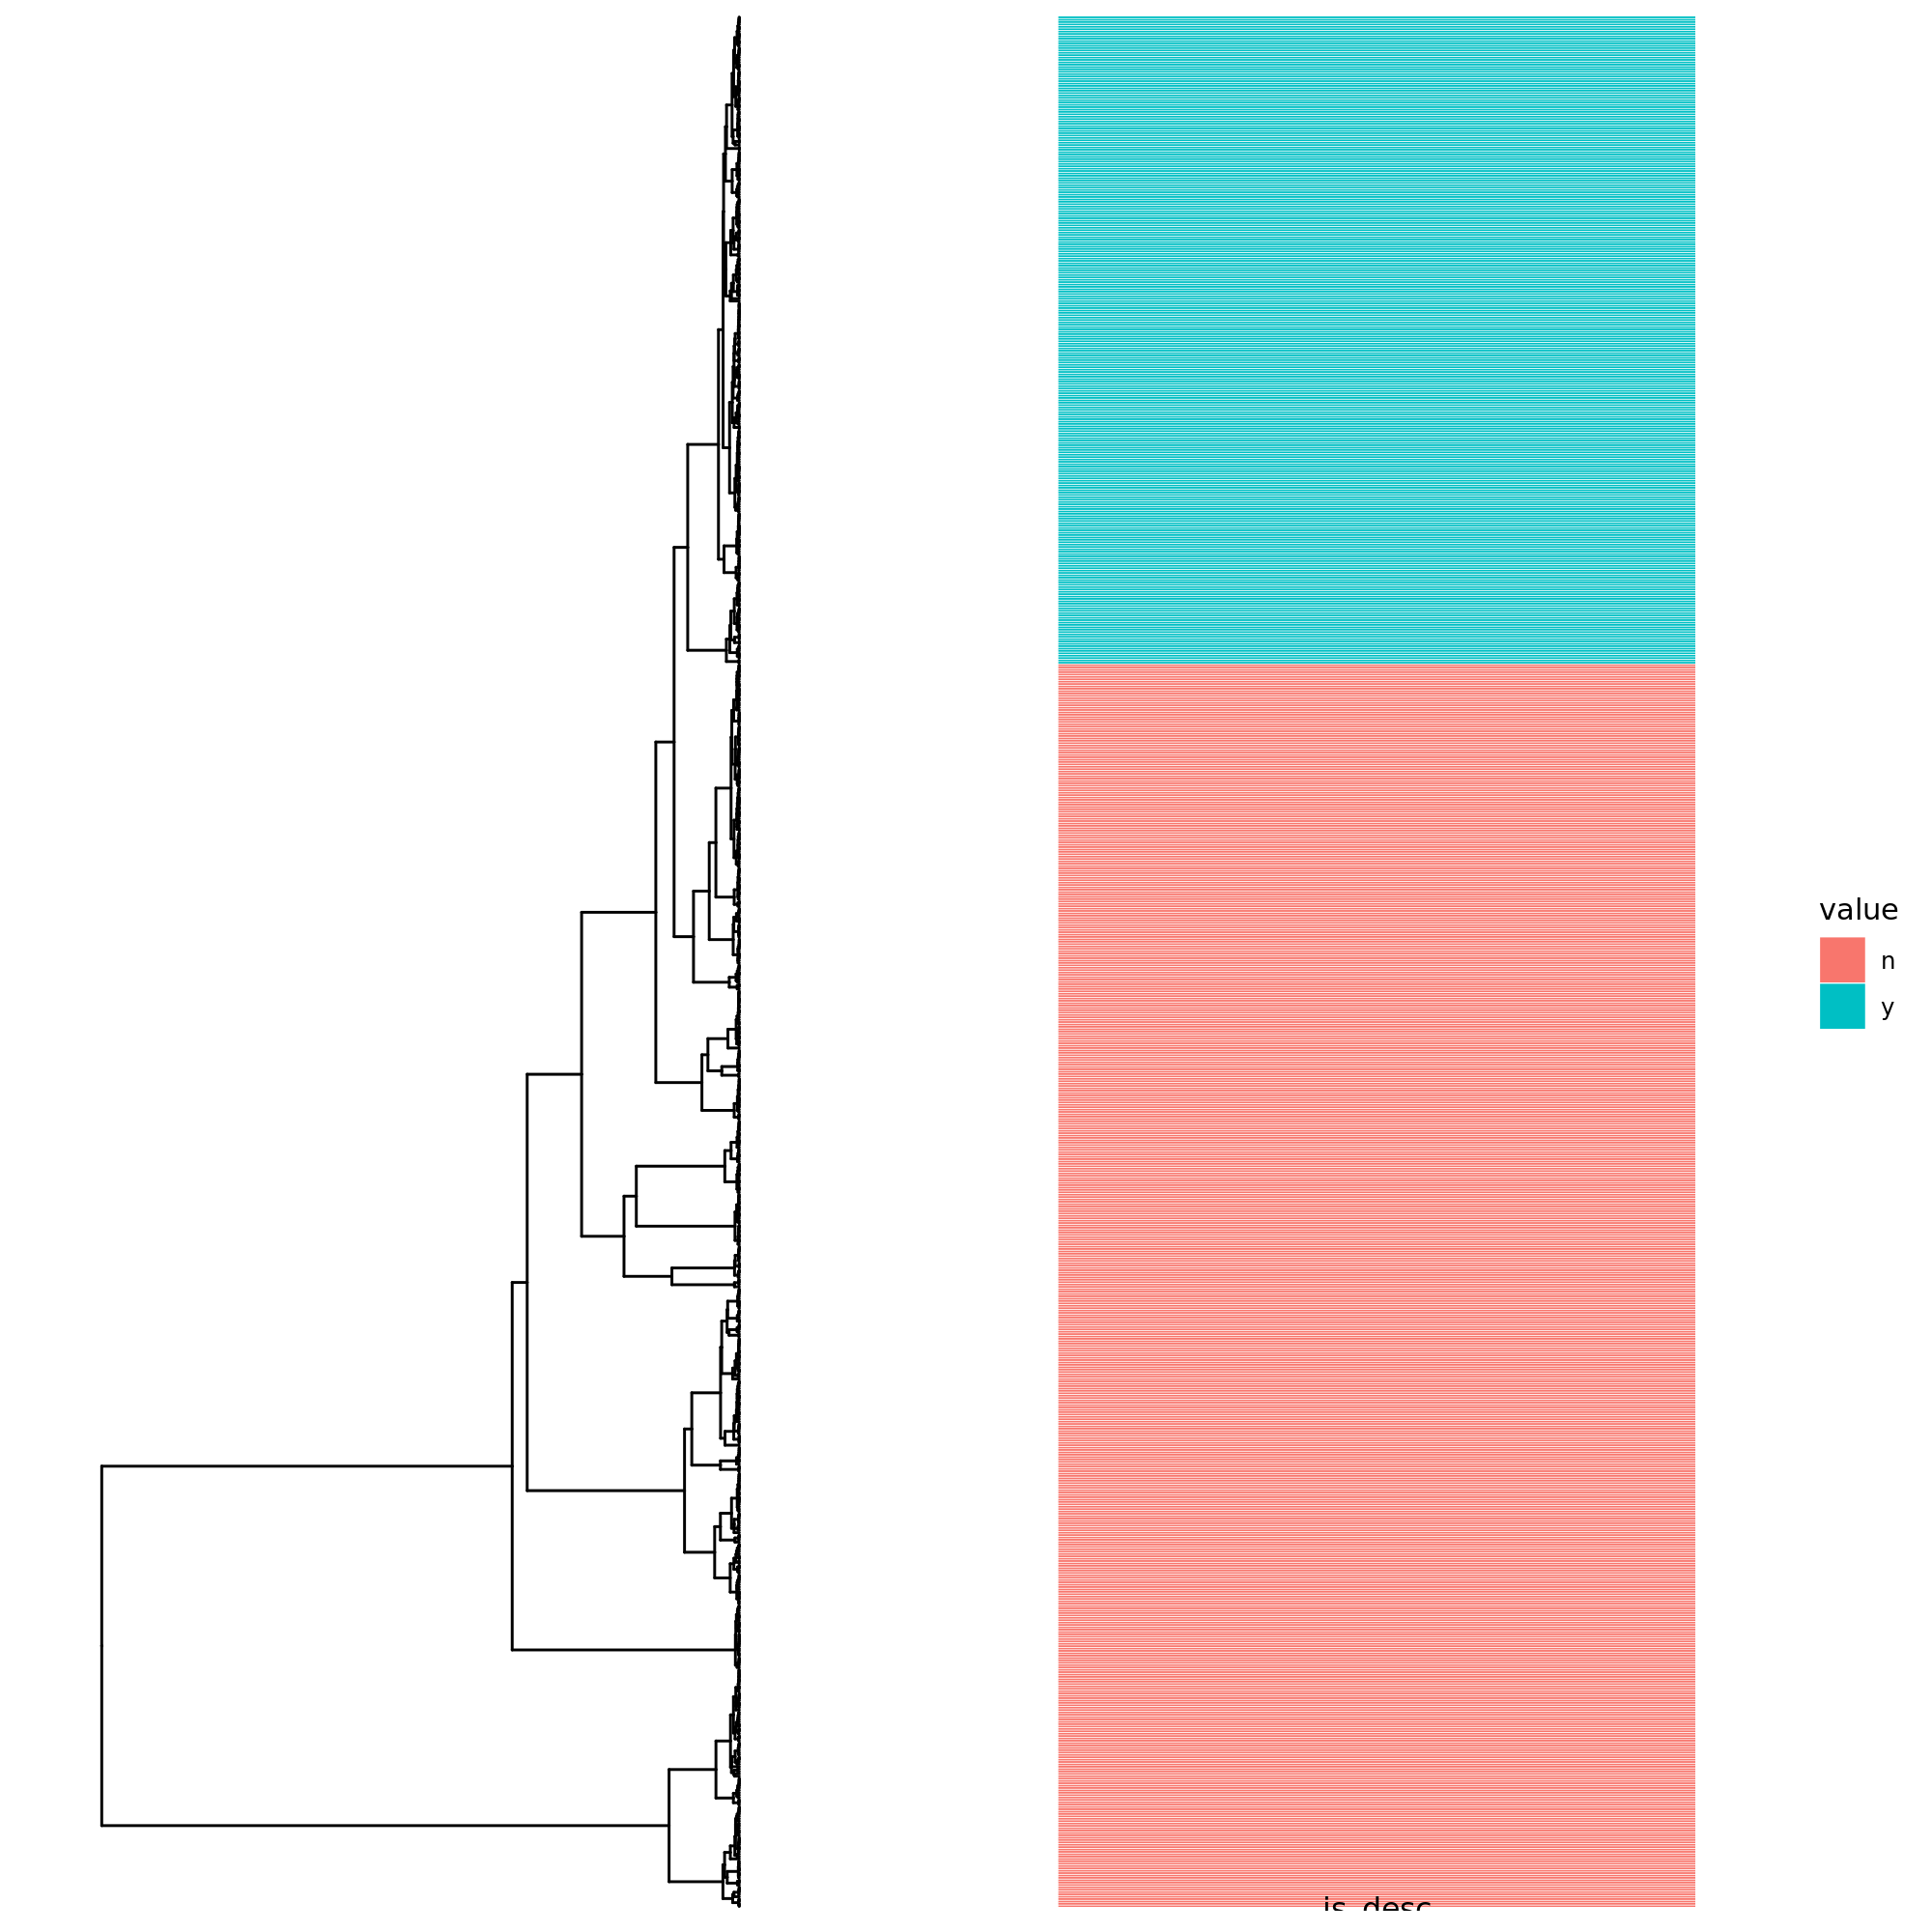

In [199]:
p <- ggtree(tree)
gheatmap(p, node_data1_tip[, c('is_desc'), drop=F])

In [127]:
p1 <- ggtree(tree) %<+% node_data1_tip +
    geom_point2(aes(subset=(node<=Ntip(tree))), fill = ifelse(node_data1_tip$site4=='x', 'red', 'blue')) +
    geom_point2(aes(subset=(node<=Ntip(tree))), shape = 21,  fill = ifelse(node_data1_tip$site5 == "x", "red", "blue"), position = position_nudge(x = 0.02))
p1
node_data2 <- data.frame(node = 1:(tree$Nnode + Ntip(tree)),
                         site4 = sim_msa_comut[node_labels, 4],
                         site5 = sim_msa_comut[node_labels, 5])
node_data2_tip <- node_data2[which(node_data2$node <= Ntip(tree)), ]

p2 <- ggtree(tree) %<+% node_data2_tip +
    geom_point2(fill = ifelse(node_data2_tip$site4=='x', 'red', 'blue')) +
    geom_point2(aes(subset=(node<=Ntip(tree))), fill = ifelse(node_data2_tip$site5 == "x", "red", "blue"), position = position_nudge(x = 0.02)) +
    geom_point2(aes(subset=(node==2454)), shape=21, size=5, fill='green')
    
p1|p2

,node,site4,site5
,<int>,<chr>,<chr>
t1,1,y,y
t2,2,y,x
t3,3,x,x
t4,4,y,y
t5,5,y,x
t6,6,y,y
t7,7,y,x
t8,8,x,y
t9,9,y,y


In [ ]:
# merge the independant sites to the coevolving sites by row names
# write the simulation result
write.dna(sim_msa, outfile, format = "fasta", colsep = "")
